# Swin Transformer in PyTorch

https://github.com/lukysummer/Vision-Transformer-in-PyTorch/blob/main/ViT_Fine_Tuning.ipynb

https://github.com/jacobgil/pytorch-grad-cam

https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/swin_transformer.py

## Import your Google drive if necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 7.4 MB/s 


In [ ]:
!pip install ttach

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import random
import numpy as np
import timm
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2

from datetime import datetime

In [ ]:
modelPath = (
    "/content/drive/MyDrive/models/torchSwinT/swin_base_patch4_window7_224_22kto1k.pth"
)
preModelName = 'swin_base_patch4_window7_224'
saveModelName = 'model_SwinT_220226.pth'
learningRate = 2e-05
nEpochs = 10

In [ ]:
def SetSeed(_seed):
    random.seed(_seed)
    np.random.seed(_seed)
    torch.manual_seed(_seed)
    torch.cuda.manual_seed_all(_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SetSeed(42)

## Define Dataloaders

In [ ]:
imageDim = 224
dirPath = '/content/drive/MyDrive/normalized-set'
batchSize = 32

In [ ]:
def LoadDataset(_dataset):
    dsPath = os.path.join(dirPath, _dataset)
    dataGenerator = transforms.Compose([
        transforms.Resize((imageDim, imageDim)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataFolder = torchvision.datasets.ImageFolder(
        root = dsPath,
        transform = dataGenerator,
    )

    datasetLoader = DataLoader(
        dataFolder,
        batch_size=batchSize,
        shuffle=True,
    )

    datasetLoader.requires_grad = True

    print(_dataset + " Class [", datasetLoader.dataset.class_to_idx, "]")
    print(_dataset + " Numbers [", len(datasetLoader.dataset.imgs), "]")
    print(_dataset + " Batch Size [", datasetLoader.batch_size, "]")

    return datasetLoader

In [ ]:
trainDataset = LoadDataset('training')
validationDataset = LoadDataset('validation')
testDataset = LoadDataset('test')

training Class [ {'benign': 0, 'malware': 1} ]
training Numbers [ 24130 ]
training Batch Size [ 32 ]
validation Class [ {'benign': 0, 'malware': 1} ]
validation Numbers [ 6890 ]
validation Batch Size [ 32 ]
test Class [ {'benign': 0, 'malware': 1} ]
test Numbers [ 3442 ]
test Batch Size [ 32 ]


## Define SwinT model from downloadable pre-trained checkpoints

In [ ]:
print("Available Swin Transformer Models: ")
timm.list_models("swin*")

Available Swin Transformer Models: 


['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224']

## Define SwinT Model

In [ ]:
class SwinTBase4(torch.nn.Module):
  def __init__(self, _nClasses, _preModelName, _modelPath, _pretrained=False):
    super(SwinTBase4, self).__init__()
    self.m_Model = timm.create_model(_preModelName, pretrained=False)

    if _pretrained:
      self.m_Model.load_state_dict(torch.load(_modelPath))

    self.m_Model.head = torch.nn.Linear(self.m_Model.head.in_features, _nClasses)

  def forward(self, _x):
    x = self.m_Model(_x)
    return x

  def TrainOneEpoch(self, _trainLoader, _criterion, _optimizer, _device):
    # keep track of training loss
    epochLoss = 0.0
    epochAccuracy = 0.0

    ####################
    # train the model  #
    ####################
    self.m_Model.train()
    for i, (data, target) in enumerate(_trainLoader):
      # move tensors to GPU if CUDA is avaliable:
      data, target = data.cuda(), target.cuda()
      
      # clear the gradients of all optimized variables
      _optimizer.zero_grad()

      # forward pass: compute predicted outputs by passing inputs to the model
      output = self.forward(data)

      # calculate the batch loss
      loss = _criterion(output, target)

      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calculate Accuracy
      accuracy = (output.argmax(dim=1) == target).float().mean()

      # update training loss and accuracy
      epochLoss = epochLoss + loss
      epochAccuracy = epochAccuracy + accuracy

      # perform a single optimization step (parameter update)
      _optimizer.step()
    
    return epochLoss / len(_trainLoader), epochAccuracy / len(_trainLoader)

  def ValidateOneEpoch(self, _validLoader, _criterion, _device):
    # keep track of validation loss
    validLoss = 0.0
    validAccuracy = 0.0

    ######################
    # validate the model #
    ######################
    self.m_Model.eval()

    for data, target in _validLoader:
      # move tensors to PUT if CUDA is avaliable
      data, target = data.cuda(), target.cuda()

      with torch.no_grad():
        # forward pass: compute predicted outputs by passing inputs to the model
        output = self.m_Model(data)

        # calculate the batch loss
        loss = _criterion(output, target)

        # Calculate Accuracy
        accuracy = (output.argmax(dim=1) == target).float().mean()

        # update average validation loss and accuracy
        validLoss = validLoss + loss
        validAccuracy = validAccuracy + accuracy

    return validLoss / len(_validLoader), validAccuracy / len(_validLoader)

## Define SwinT Fine-tuning Function

In [ ]:
def TrainModel(_model, _epochs, _device, _criterion, _optimizer, _trainLoader, _validLoader=None):
  validLossMin = np.Inf # track change in validation loss

  # keeping track of losses as it happen
  trainLosses = list()
  validLosses = list()
  trainAccs = list()
  validAccs = list()
  
  for epoch in range(1, _epochs + 1):
    gc.collect()
    trainLoss, trainAcc = _model.TrainOneEpoch(_trainLoader, _criterion, _optimizer, _device)
    print(f"[TRAIN] EPOCH {epoch} - LOSS: {trainLoss}, ACCURACY: {trainAcc}")
    trainLosses.append(trainLoss.item())
    trainAccs.append(trainAcc.item())
    gc.collect()

    if _validLoader is not None:
      gc.collect()
      validLoss, validAcc = _model.ValidateOneEpoch(_validLoader, _criterion, _device)
      print(f"[VALID] EPOCH {epoch} - LOSS: {validLoss}, ACCURACY: {validAcc}")
      validLosses.append(validLoss.item())
      validAccs.append(validAcc.item())
      gc.collect()

      if validLoss <= validLossMin and epoch != 1:
        print("Validation loss decreased ({:.4f} --> {:.4f}). Saving model ...".format(validLossMin, validLoss))
        torch.save(_model.state_dict(), 'best_model.pth')
      validLossMin = validLoss
  
  return trainLosses, validLosses, trainAccs, validAccs

## Fine-tune SwinT!

In [ ]:
model = SwinTBase4(_nClasses=2, _preModelName=preModelName, _modelPath=modelPath, _pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
startTime = datetime.now()
print(f"Start Time: {startTime}")

trainLosses, validLosses, trainAccs, validAccs = TrainModel(model, nEpochs, device, criterion, optimizer, trainDataset, validationDataset)
print(f"Execution time: {datetime.now() - startTime}")

print("Saving Model")
torch.save(model.state_dict(), saveModelName)

Start Time: 2022-02-27 12:44:58.958693
[TRAIN] EPOCH 1 - LOSS: 0.4352997839450836, ACCURACY: 0.782988429069519
[VALID] EPOCH 1 - LOSS: 0.2634947896003723, ACCURACY: 0.8846932649612427
[TRAIN] EPOCH 2 - LOSS: 0.24813883006572723, ACCURACY: 0.8898592591285706
[VALID] EPOCH 2 - LOSS: 0.2541847825050354, ACCURACY: 0.883651614189148
Validation loss decreased (0.2635 --> 0.2542). Saving model ...
[TRAIN] EPOCH 3 - LOSS: 0.20244601368904114, ACCURACY: 0.909395694732666
[VALID] EPOCH 3 - LOSS: 0.25521206855773926, ACCURACY: 0.8939235806465149
[TRAIN] EPOCH 4 - LOSS: 0.16830900311470032, ACCURACY: 0.9226821064949036
[VALID] EPOCH 4 - LOSS: 0.21950700879096985, ACCURACY: 0.9086805582046509
Validation loss decreased (0.2552 --> 0.2195). Saving model ...
[TRAIN] EPOCH 5 - LOSS: 0.14431725442409515, ACCURACY: 0.9332367777824402
[VALID] EPOCH 5 - LOSS: 0.22198159992694855, ACCURACY: 0.9096643924713135
[TRAIN] EPOCH 6 - LOSS: 0.13164709508419037, ACCURACY: 0.9362996816635132
[VALID] EPOCH 6 - LOSS: 0

In [ ]:
!cp /content/best_model.pth /content/drive/MyDrive/models/torchSwinT
!cp /content/model_SwinT_220226.pth /content/drive/MyDrive/models/torchSwinT

In [ ]:
def PlotGraph(_trainLosses, _trainAccs, _valLosses, _valAccs):
    fig, ax1 = plt.subplots()

    ax1.plot(_trainAccs, 'b-', label="train acc")
    ax1.plot(_valAccs, 'r-', label="valid acc")
    ax1.set_xlabel('epoch')
    # Make the y-axis label, ticks and tick labels match the line color
    ax1.set_ylabel('acc', color='k')
    ax1.tick_params('y', colors='k')

    ax2 = ax1.twinx()
    ax2.plot(_trainLosses, 'g-', label="train loss")
    ax2.plot(_valLosses, 'k-', label="valid loss")
    ax2.set_ylabel('loss', color='k')
    ax2.tick_params('y', colors='k')

    plt.legend()

    fig.tight_layout()
    plt.show()
    plt.savefig('./' + 'train-val_loss_acc.png', format='png', dpi=300)

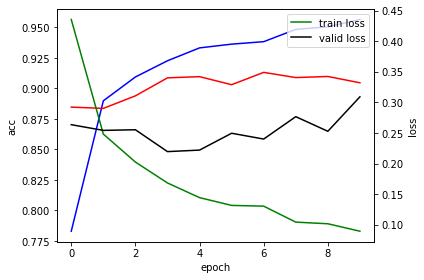

<Figure size 432x288 with 0 Axes>

In [ ]:
PlotGraph(trainLosses, trainAccs, validLosses, validAccs)

In [ ]:
# model.load_state_dict(torch.load('/content/'+saveModelName))
model.load_state_dict(torch.load('/content/drive/MyDrive/models/torchSwinT/model_SwinT_220226.pth'))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [ ]:
def TestOneEpoch(_model, _testLoader, _criterion):
      # keep track of validation loss
      testLoss = 0.0
      testAccuracy = 0.0

      labelList = list()
      predList = list()

      ##################
      # test the model #
      ##################
      
      _model.eval()

      for data, target in _testLoader:
        # move tensors to PUT if CUDA is avaliable
        data, target = data.cuda(), target.cuda()

        with torch.no_grad():
          # forward pass: compute predicted outputs by passing inputs to the model
          output = _model(data)

          # calculate the batch loss
          loss = _criterion(output, target)

          # Calculate Accuracy
          accuracy = (output.argmax(dim=1) == target).float().mean()

          # update average validation loss and accuracy
          testLoss = testLoss + loss
          testAccuracy = testAccuracy + accuracy

          _, pred = torch.max(output, 1)
          labelList.extend(target.tolist())
          predList.extend(pred.tolist())


          # print(f"[TEST] LOSS: {testLoss}, ACCURACY: {testAccuracy}")

      return testLoss / len(_testLoader), testAccuracy / len(_testLoader), labelList, predList

In [ ]:
def ConfusionMatrix(_nClasses, _labelList, _predList):
    cm = confusion_matrix(_labelList, _predList, labels=[i for i in range(_nClasses)])
    print(cm)

    report = classification_report(_labelList, _predList, labels=[i for i in range(_nClasses)])
    print(report)


In [ ]:
startTime = datetime.now()
print(f"Start Time: {startTime}")
testLoss, testAccuracy, labelList, predList = TestOneEpoch(model, testDataset, criterion)
print(f"Execution time: {datetime.now() - startTime}")

print(f"[TEST] LOSS: {testLoss}, ACCURACY: {testAccuracy}")
ConfusionMatrix(_nClasses=2, _labelList=labelList, _predList=predList)

Start Time: 2022-02-27 16:05:05.744021
Execution time: 0:15:47.567778
[TEST] LOSS: 0.3384000062942505, ACCURACY: 0.9039351940155029
[[1399  262]
 [  70 1711]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1661
           1       0.87      0.96      0.91      1781

    accuracy                           0.90      3442
   macro avg       0.91      0.90      0.90      3442
weighted avg       0.91      0.90      0.90      3442



# Get GradCAM

## Define Utils

In [ ]:
def ScaleCamImage(_cam, _targetSize=None):
    result = list()
    for image in _cam:
        image = image - np.min(image)
        image = image / (1e-7 + np.max(image)) 
        if _targetSize is not None:
            image = cv2.resize(image, _targetSize)
        result.append(image)
    result = np.float32(result)

    return result

def Get2dProjection(_activationBatch):
    # TBD: use pytorch batch svd implementation
    _activationBatch[np.isnan(_activationBatch)] = 0
    projections = list()

    for activations in _activationBatch:
        reshapedActivation = (activations).reshape(activations.shape[0], -1).transpose()

        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshapedActivation = reshapedActivation - reshapedActivation.mean(axis=0)
        U, S, VT = np.linalg.svd(reshapedActivation, full_matrices=True)
        projection = np.matmul(reshapedActivation, VT[0, :])
        projections.append(projection)

    return np.float32(projections)


class ClassifierOutputTarget:
    def __init__(self, _category):
        self.m_Category = _category
    def __call__(self, _modelOutput):
        if len(_modelOutput.shape) == 1:
            return _modelOutput[self.m_Category]
        return _modelOutput[:, self.m_Category]

class ActivationAndGradients:
    """
    Class for extracting activations and
    registering gradients from targetted intermediate layers
    
    """

    def __init__(self, _model, _targetLayers, _reshapedTransform):
        self.m_Model = _model
        self.m_Gradients = list()
        self.m_Activations = list()
        self.m_ReshapedTransform = _reshapedTransform
        self.m_Handles = list()

        self.m_Handles.append(_targetLayers.register_forward_hook(self.SaveActivation))
        self.m_Handles.append(_targetLayers.register_forward_hook(self.SaveGradient))

    def SaveActivation(self, _module, _input, _output):
        activation = _output

        if self.m_ReshapedTransform is not None:
            activation = self.m_ReshapedTransform(activation)
        self.m_Activations.append(activation.cpu().detach())

    def SaveGradient(self, _module, _input, _output):
        if not hasattr(_output, "requires_grad") or not _output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _StoreGrad(_grad):
            if self.m_ReshapedTransform is not None:
                _grad = self.m_ReshapedTransform(_grad)
            self.m_Gradients = [_grad.cpu().detach()] + self.m_Gradients

        _output.register_hook(_StoreGrad)

    def __call__(self, _x):
        self.m_Gradients = list()
        self.m_Activations = list()
        return self.m_Model(_x)

    def Release(self):
        for handle in self.m_Handles:
            handle.remove()


## Define GradCAM

In [ ]:
class BaseCAM:
    def __init__(self, _model, _targetLayers, _useCuda=False, _reshapeTransform=None, _computeInputGradient=False, _usesGradients=True):
        """
        # from typing import Callable, List, Tuple #
        Args type
            _model: torch.nn.Module
            _targetLayers: List[torch.nn.Module]
            _useCuda: bool
            _reshapeTransform: Callable
            _computeInputGradient: bool
            _usesGradients: bool        
        
        Return type
            : None
        """

        self.m_Model = _model.eval()
        self.m_TargetLayers = _targetLayers
        self.m_Cuda = _useCuda

        if self.m_Cuda:
            self.m_Model = _model.cuda()

        self.m_ReshapeTransform = _reshapeTransform
        self.m_ComputeInputGradient = _computeInputGradient
        self.m_UsesGradients = _usesGradients
        self.m_ActivationsAndGrads = ActivationAndGradients(self.m_Model, _targetLayers, _reshapeTransform)

    ##################################################################
    # Get a vector of weights for every channel in the target layer. #
    # Methods that return weights channels,                          #
    # will typically need to only implement this function.           #
    # ################################################################ 

    def GetCamWeights(self, _inputTensor, _targetLayers, _targets, _activations, _grads):
        """
        Args type
            _inputTensor: torch.Tensor
            _targetLayers: Listp[torch.nn.Module]
            _targets: List[torch.nn.Module]
            _activations: torch.Tensor
            _grads: torch.Tensor
        
        Return type
            : np.ndarray
        
        """
        raise Exception("Not Implemented")

    def GetCamImage(self, _inputTensor, _targetLayer, _targets, _activations, _grads, _eigenSmooth=False):
        """
        Args type
            _inputTensor: torch.Tensor
            _targetLayer: torch.nn.Module
            _targets: List[torch.nn.Module]
            _activations: torch.Tensor
            _grads: torch.Tensor
            _eigenSmooth: bool
        
        Return type
            cam: np.ndarray
        
        """

        weights = self.GetCamWeights(_inputTensor, _targetLayer, _targets, _activations, _grads)
        weightedActivations = weights[:, None, None] * _activations
        # weightedActivations = weights[:, :, None, None] * _activations

        if _eigenSmooth:
            cam = Get2dProjection(weightedActivations)

        else:
            cam = weightedActivations.sum(axis=1)
        return cam

    def Forward(self, _inputTensor, _targets, _eigenSmooth=False):
        """
        Args type
            _inputTensor: torch.Tensor
            _targets: List[torch.nn.Module]
            _eigenSmooth: bool

        Return type
            : np.ndarray

        """

        if self.m_Cuda:
            _inputTensor = _inputTensor.cuda()

        if self.m_ComputeInputGradient:
            _inputTensor = torch.autograd.Variable(_inputTensor, requires_grad=True)

        outputs = self.m_ActivationsAndGrads(_inputTensor)
        if _targets is None:
            targetCategories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            _targets = [ClassifierOutputTarget(category) for category in targetCategories]

        if self.m_UsesGradients:
            self.m_Model.zero_grad()
            loss = sum([target(output) for target, output in zip(_targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # coputed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        camPerLayer = self.ComputeCamPerLayer(_inputTensor, _targets, _eigenSmooth)

        return self.AggregateMultiLayers(camPerLayer)

    def GetTargetWidthHeight(self, _inputTensor):
        """
        Args type
            _inputTensor: torch.Tensor

        Return type
            width, height: Tuple[int, int]
        
        """
        width, height = _inputTensor.size(-1), _inputTensor.size(-2)

        return width, height


    def ComputeCamPerLayer(self, _inputTensor, _targets, _eigenSmooth):
        """
        Args type
            _inputTensor: torch.Tensor
            _targets: List[torch.nn.Module]
            _eigenSmooth: bool

        Return type
            camPerTargetLayer: np.ndarray
        
        """

        activationsList = [acti.cpu().data.numpy() for acti in self.m_ActivationsAndGrads.m_Activations]
        gradsList = [grad.cpu().data.numpy() for grad in self.m_ActivationsAndGrads.m_Gradients]
        targetSize = self.GetTargetWidthHeight(_inputTensor)

        camPertargetLayer = list()
        
        # # Loop over the saliency image from every layer
        # for i in range(len(self.m_TargetLayers)):
        #     targetLayer = self.m_TargetLayers[i]
        #     layerActivations = None
        #     layerGrads = None

        #     if i < len(activationsList):
        #         layerActivations = activationsList[i]

        #     if i < len(gradsList):
        #         layerGrads = gradsList[i]

        #     cam = self.GetCamImage(_inputTensor, targetLayer, _targets, layerActivations, layerGrads, _eigenSmooth)
        #     cam = np.maximum(cam, 0)
        #     scaled = ScaleCamImage(cam, targetSize)
        #     camPertargetLayer.append(scaled[:, None, :])

        targetLayer = self.m_TargetLayers
        layerActivations = None
        layerGrads = None

        layerActivations = activationsList
        layerGrads = gradsList

        cam = self.GetCamImage(_inputTensor, targetLayer, _targets, layerActivations, layerGrads, _eigenSmooth)
        cam = np.maximum(cam, 0)
        scaled = ScaleCamImage(cam, targetSize)
        camPertargetLayer.append(scaled[:, None, :])

        return camPertargetLayer

    def AggregateMultiLayers(self, _camPerTargetLayer):
        """
        Args type
            _camPerTargetLayer: np.ndarray

        Return type
            ScaleCamImage(result): np.ndarray
        
        """

        camPerTargetLayer = np.concatenate(_camPerTargetLayer, axis=1)
        camPerTargetLayer = np.maximum(camPerTargetLayer, 0)
        result = np.mean(camPerTargetLayer, axis=1)

        return ScaleCamImage(result)

    def __call__(self, _inputTensor, _targets=None, _eigenSmooth=False):
        """
        Args type:
            _inputTensor: torch.Tensor
            _targets: List[torch.nn.Module]
            _eigenSmooth: bool

        Return type
            self.Forward(_inputTensor, _targets, _eigenSmooth): np.ndarray
        
        """

        return self.Forward(_inputTensor, _targets, _eigenSmooth)

    def __del__(self):
        self.m_ActivationsAndGrads.Release()

    def __enter__(self):
        return self

    def __exit__(self, _excType, _excValue, _excTb):
        self.m-ActivationAndGradients.Release()
        if isinstance(_excValue, IndexError):
            # Handle IndexError here...
            print(f"An exception occurred in CAM with block: {_excType}. Message: {_excValue}")
            return True

In [ ]:
class GradCAM(BaseCAM):
    def __init__(self, _model, _targetLayers, _useCuda=False, _reshapeTransform=None):
        super(GradCAM, self).__init__(_model, _targetLayers, _useCuda, _reshapeTransform)

    def GetCamWeights(self, _inputTensor, _targetLayer, _targetCategory, _activations, _grads):
        return np.mean(_grads, axis=(1, 2))

## Apply a target layer to GradCAM

In [ ]:
# create heatmap from mask on image
def ShowCamOnImage(_img, _mask):
  heatmap = cv2.applyColorMap(np.uint8(255 * _mask), cv2.COLORMAP_JET)
  heatmap = np.float32(heatmap) / 255
  cam = heatmap + np.float32(_img)
  cam = cam / np.max(cam)

  return cam

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
targetLayer = model.m_Model.layers[-1].blocks[-1].norm1
targetLayer

LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

In [ ]:
sampleDataset = next(iter(testDataset))

In [ ]:
cam = GradCAM(_model=model, _targetLayers=targetLayer, _useCuda=True)

In [ ]:
grayscaleCam = cam(_inputTensor=sampleDataset[0])
grayscaleCam = grayscaleCam[0, :]
print(grayscaleCam)
print(grayscaleCam.shape)

[[0.0000000e+00 5.7880399e-03 2.9360464e-01 ... 0.0000000e+00
  1.2107990e-02 0.0000000e+00]
 [0.0000000e+00 5.7880399e-03 2.9360464e-01 ... 0.0000000e+00
  1.2107990e-02 0.0000000e+00]
 [1.8890363e-03 5.5167256e-03 2.7984193e-01 ... 2.3780091e-04
  1.3813153e-02 3.9540110e-03]
 ...
 [2.7019009e-01 4.0436212e-02 0.0000000e+00 ... 3.5165458e-03
  0.0000000e+00 1.7071898e-01]
 [2.7871838e-01 3.7071638e-02 0.0000000e+00 ... 2.9661190e-03
  0.0000000e+00 1.7759763e-01]
 [2.7871838e-01 3.7071638e-02 0.0000000e+00 ... 2.9661190e-03
  0.0000000e+00 1.7759763e-01]]
(224, 224)


In [ ]:
testImage = sampleDataset[0][0].numpy()
testImage = np.transpose(testImage, (1, 2, 0))

In [ ]:
visualization = ShowCamOnImage(testImage, grayscaleCam)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


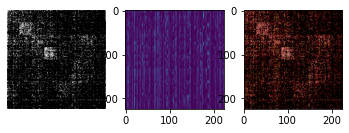

In [ ]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(testImage)
axs[0].axis('off')

axs[1].imshow(grayscaleCam)
axs[2].imshow(visualization)